## 1. INITIATION & READING DATA

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', -1)

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

print('** M5 - FORECASTING - ACCURACY **')
print("-"*25)

import gc
import os
for x in os.listdir("input/"):
    print(x)
print("-"*25)

print ("Initiation is DONE !!")
print("-"*25)

** M5 - FORECASTING - ACCURACY **
-------------------------
calendar.csv
model_raw_lgbm1_regression_gbdt_0.3_0.3_0.3.txt
sales_train_evaluation.csv
sales_train_validation.csv
sample_submission.csv
sell_prices.csv
-------------------------
Initiation is DONE !!
-------------------------


In [2]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

In [3]:
##### SOME USEFULL FUNCTIONS

## TIMER
import time
from contextlib import contextmanager
@contextmanager
def timer():
    t0 = time.time()
    yield
    t1 = time.time()
    print( 'Runtime: ' + str(round(t1-t0,2)) + ' sn' )

In [4]:
path = 'input/'

with timer():
    calendar   = pd.read_csv( f'{path}calendar.csv')
#    train_v    = pd.read_csv( f'{path}sales_train_validation.csv')
    train    = pd.read_csv( f'{path}sales_train_evaluation.csv')
    prices     = pd.read_csv( f'{path}sell_prices.csv')
    submission = pd.read_csv( f'{path}sample_submission.csv')

print('Reading Data is DONE !!')
print("-"*25)

print( f'calendar   shape :  {calendar.shape}    ')
#print( f'train_v    shape :  {train_v.shape}     ')
print( f'train    shape :  {train.shape}     ')
print( f'prices     shape :  {prices.shape}      ')
print( f'submission shape :  {submission.shape}  ')

Runtime: 5.74 sn
Reading Data is DONE !!
-------------------------
calendar   shape :  (1969, 14)    
train    shape :  (30490, 1947)     
prices     shape :  (6841121, 4)      
submission shape :  (60980, 29)  


## 2. BASIC PREPROCESSING

In [5]:
print(train.shape)
print('-'*25)
train.head()

(30490, 1947)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,...,d_1443,d_1444,d_1445,d_1446,d_1447,d_1448,d_1449,d_1450,d_1451,d_1452,d_1453,d_1454,d_1455,d_1456,d_1457,d_1458,d_1459,d_1460,d_1461,d_1462,d_1463,d_1464,d_1465,d_1466,d_1467,d_1468,d_1469,d_1470,d_1471,d_1472,d_1473,d_1474,d_1475,d_1476,d_1477,d_1478,d_1479,d_1480,d_1481,d_1482,d_1483,d_1484,d_1485,d_1486,d_1487,d_1488,d_1489,d_1490,d_1491,d_1492,d_1493,d_1494,d_1495,d_1496,d_1497,d_1498,d_1499,d_1500,d_1501,d_1502,d_1503,d_1504,d_1505,d_1506,d_1507,d_1508,d_1509,d_1510,d_1511,d_1512,d_1513,d_1514,d_1515,d_1516,d_1517,d_1518,d_1519,d_1520,d_1521,d_1522,d_1523,d_1524,d_1525,d_1526,d_1527,d_1528,d_1529,d_1530,d_1531,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,d_1552,d_1553,d_1554,d_1555,d_1556,d_1557,d_1558,d_1559,d_1560,d_1561,d_1562,d_1563,d_1564,d_1565,d_1566,d_1567,d_1568,d_1569,d_1570,d_1571,d_1572,d_1573,d_1574,d_1575,d_1576,d_1577,d_1578,d_1579,d_1580,d_1581,d_1582,d_1583,d_1584,d_1585,d_1586,d_1587,d_1588,d_1589,d_1590,d_1591,d_1592,d_1593,d_1594,d_1595,d_1596,d_1597,d_1598,d_1599,d_

In [6]:
train['id'] = train['item_id'] + '_' + train['store_id']
print(train.shape)
print('-'*25)
train.head()

(30490, 1947)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,...,d_1443,d_1444,d_1445,d_1446,d_1447,d_1448,d_1449,d_1450,d_1451,d_1452,d_1453,d_1454,d_1455,d_1456,d_1457,d_1458,d_1459,d_1460,d_1461,d_1462,d_1463,d_1464,d_1465,d_1466,d_1467,d_1468,d_1469,d_1470,d_1471,d_1472,d_1473,d_1474,d_1475,d_1476,d_1477,d_1478,d_1479,d_1480,d_1481,d_1482,d_1483,d_1484,d_1485,d_1486,d_1487,d_1488,d_1489,d_1490,d_1491,d_1492,d_1493,d_1494,d_1495,d_1496,d_1497,d_1498,d_1499,d_1500,d_1501,d_1502,d_1503,d_1504,d_1505,d_1506,d_1507,d_1508,d_1509,d_1510,d_1511,d_1512,d_1513,d_1514,d_1515,d_1516,d_1517,d_1518,d_1519,d_1520,d_1521,d_1522,d_1523,d_1524,d_1525,d_1526,d_1527,d_1528,d_1529,d_1530,d_1531,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,d_1552,d_1553,d_1554,d_1555,d_1556,d_1557,d_1558,d_1559,d_1560,d_1561,d_1562,d_1563,d_1564,d_1565,d_1566,d_1567,d_1568,d_1569,d_1570,d_1571,d_1572,d_1573,d_1574,d_1575,d_1576,d_1577,d_1578,d_1579,d_1580,d_1581,d_1582,d_1583,d_1584,d_1585,d_1586,d_1587,d_1588,d_1589,d_1590,d_1591,d_1592,d_1593,d_1594,d_1595,d_1596,d_1597,d_1598,d_1599,d_

In [7]:
# Making data usable in data
with timer():
    train = pd.melt( train,
                     id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                     value_vars = [col for col in train.columns if col.startswith("d_")],
                     var_name = "d",
                     value_name = "sales")
with timer():
    train['d'] = train['d'].str.extract('(\d+)').astype(int)
    
with timer():
    train.sort_values(['id', 'd'], inplace=True)
    
print(train.shape)
print('-'*25)
train.tail()

Runtime: 9.38 sn
Runtime: 100.69 sn
Runtime: 46.97 sn
(59181090, 8)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
59057692,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1937,0
59088182,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1938,0
59118672,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1939,0
59149162,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1940,0
59179652,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1941,0


In [8]:
# Adding the 28 days we try to forecast
with timer():
    tmp = train.groupby('id', as_index=False ).tail(28)
    tmp['d'] = tmp['d'] + 28
    tmp['sales'] = np.nan
    print(tmp.shape)

with timer():
    train = pd.concat([train,tmp], axis=0, sort=False, ignore_index=True)

with timer():
    train.sort_values(['id', 'd'], inplace=True)
    train.reset_index(drop=True, inplace=True)
    
print(train.shape)
print('-'*25)
train.tail()

(853720, 8)
Runtime: 5.64 sn
Runtime: 1.83 sn
Runtime: 29.56 sn
(60034810, 8)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
60034805,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1965,NaN
60034806,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1966,NaN
60034807,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1967,NaN
60034808,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1968,NaN
60034809,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1969,NaN


In [9]:
print(calendar.shape)
print('-'*25)
calendar.head()

(1969, 14)
-------------------------


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [10]:
with timer():
    calendar['d'] = calendar['d'].str.extract('(\d+)').astype(int)
    
print(calendar.shape)
print('-'*25)
calendar.head(10)

Runtime: 0.04 sn
(1969, 14)
-------------------------


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,10,NaN,NaN,NaN,NaN,1,1,0


In [11]:
# Merging calendar 
with timer():
    train = train.merge(calendar, on='d', how='left')

print(train.shape)
print('-'*25)
train.tail()

Runtime: 41.65 sn
(60034810, 21)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
60034805,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1965,NaN,2016-06-15,11620,Wednesday,5,6,2016,NaN,NaN,NaN,NaN,0,1,1
60034806,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1966,NaN,2016-06-16,11620,Thursday,6,6,2016,NaN,NaN,NaN,NaN,0,0,0
60034807,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1967,NaN,2016-06-17,11620,Friday,7,6,2016,NaN,NaN,NaN,NaN,0,0,0
60034808,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1968,NaN,2016-06-18,11621,Saturday,1,6,2016,NaN,NaN,NaN,NaN,0,0,0
60034809,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1969,NaN,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [12]:
print(prices.shape)
print('-'*25)
prices.head()

(6841121, 4)
-------------------------


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [13]:
# Merging prices 
with timer():
    train = train.merge(prices, on=['item_id','store_id','wm_yr_wk'], how='left')

print(train.shape)
print('-'*25)
train.tail()

Runtime: 52.65 sn
(60034810, 22)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
60034805,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1965,NaN,2016-06-15,11620,Wednesday,5,6,2016,NaN,NaN,NaN,NaN,0,1,1,5.94
60034806,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1966,NaN,2016-06-16,11620,Thursday,6,6,2016,NaN,NaN,NaN,NaN,0,0,0,5.94
60034807,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1967,NaN,2016-06-17,11620,Friday,7,6,2016,NaN,NaN,NaN,NaN,0,0,0,5.94
60034808,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1968,NaN,2016-06-18,11621,Saturday,1,6,2016,NaN,NaN,NaN,NaN,0,0,0,5.94
60034809,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1969,NaN,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,5.94


In [14]:
cols_to_drop = ['id', 'cat_id', 'state_id', 'wday', 'date']
train.drop(cols_to_drop, axis=1, inplace=True)

print(train.shape)
print('-'*25)
train.tail()

(60034810, 17)
-------------------------


,item_id,dept_id,store_id,d,sales,wm_yr_wk,weekday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
60034805,HOUSEHOLD_2_516,HOUSEHOLD_2,WI_3,1965,NaN,11620,Wednesday,6,2016,NaN,NaN,NaN,NaN,0,1,1,5.94
60034806,HOUSEHOLD_2_516,HOUSEHOLD_2,WI_3,1966,NaN,11620,Thursday,6,2016,NaN,NaN,NaN,NaN,0,0,0,5.94
60034807,HOUSEHOLD_2_516,HOUSEHOLD_2,WI_3,1967,NaN,11620,Friday,6,2016,NaN,NaN,NaN,NaN,0,0,0,5.94
60034808,HOUSEHOLD_2_516,HOUSEHOLD_2,WI_3,1968,NaN,11621,Saturday,6,2016,NaN,NaN,NaN,NaN,0,0,0,5.94
60034809,HOUSEHOLD_2_516,HOUSEHOLD_2,WI_3,1969,NaN,11621,Sunday,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,5.94


In [15]:
cat_cols     = [ 'item_id', 'dept_id', 'store_id', 'weekday', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2' ]

for col in cat_cols:
    train[col] = train[col].astype('category')

print(train.shape)
print('-'*25)
train.tail()

(60034810, 17)
-------------------------


,item_id,dept_id,store_id,d,sales,wm_yr_wk,weekday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
60034805,HOUSEHOLD_2_516,HOUSEHOLD_2,WI_3,1965,NaN,11620,Wednesday,6,2016,NaN,NaN,NaN,NaN,0,1,1,5.94
60034806,HOUSEHOLD_2_516,HOUSEHOLD_2,WI_3,1966,NaN,11620,Thursday,6,2016,NaN,NaN,NaN,NaN,0,0,0,5.94
60034807,HOUSEHOLD_2_516,HOUSEHOLD_2,WI_3,1967,NaN,11620,Friday,6,2016,NaN,NaN,NaN,NaN,0,0,0,5.94
60034808,HOUSEHOLD_2_516,HOUSEHOLD_2,WI_3,1968,NaN,11621,Saturday,6,2016,NaN,NaN,NaN,NaN,0,0,0,5.94
60034809,HOUSEHOLD_2_516,HOUSEHOLD_2,WI_3,1969,NaN,11621,Sunday,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,5.94


In [16]:
pred = train[train['d'] > 1913]
y_true = pred[['sales']]
pred = pred.drop('sales', axis=1)
print(pred.shape)

test = train[ (train['d'] <= 1941) & (train['d'] > 1913) ]
print(test.shape)

train = train[train['d'] < 1913]
print(train.shape)

(1707440, 16)
(853720, 17)
(58296880, 17)


In [17]:
x_train = train.drop('sales', axis=1)
y_train = train['sales']

x_test = test.drop('sales', axis=1)
y_test = test['sales']

In [18]:
feature_columns_to_keep = x_train.columns

In [19]:
train_data = lgb.Dataset( x_train, label = y_train, categorical_feature = cat_cols, free_raw_data=False )
valid_data = lgb.Dataset( x_test,  label = y_test,  categorical_feature = cat_cols, free_raw_data=False )

In [20]:
out_path = 'output/'

In [21]:
del calendar, prices, train, test,  tmp, x_train, x_test, y_train, y_test  ; gc.collect()

115

Training until validation scores don't improve for 250 rounds
[20]	valid_0's rmse: 2.34441
[40]	valid_0's rmse: 2.27461
[60]	valid_0's rmse: 2.25165
[80]	valid_0's rmse: 2.23894
[100]	valid_0's rmse: 2.23237
[120]	valid_0's rmse: 2.22925
[140]	valid_0's rmse: 2.21503
[160]	valid_0's rmse: 2.20534
[180]	valid_0's rmse: 2.19923
[200]	valid_0's rmse: 2.1945
[220]	valid_0's rmse: 2.19251
[240]	valid_0's rmse: 2.19208
Did not meet early stopping. Best iteration is:
[249]	valid_0's rmse: 2.19115
Runtime: 338.72 sn


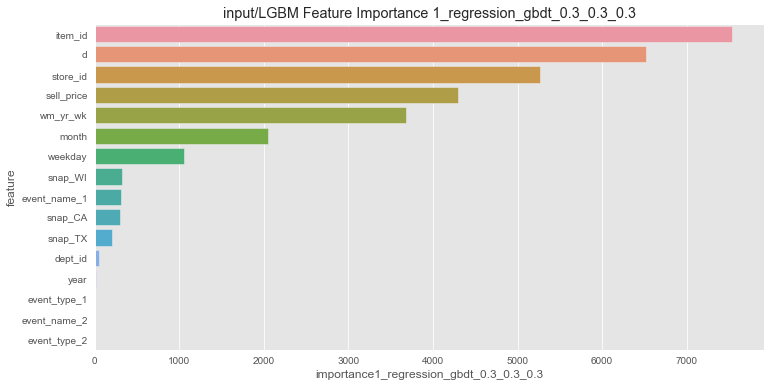

-------------------------
   i   objective boosting  learning_rate   l1   l2      RMSE
0  1  regression  gbdt     0.3            0.3  0.3  2.191149
-------------------------


In [22]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = feature_columns_to_keep


obj_list   = [ 'regression' ]
boost_list = [ 'gbdt']
lr_list    = [ 0.3]
l1_list    = [ 0.3]
l2_list    = [ 0.3]

res_rmse = pd.DataFrame()

i=0



for obj in obj_list:
    for boost in boost_list:
        for lr in lr_list: 
            for l1 in l1_list:
                for l2 in l2_list:
                    i += 1
                    param_name = f'{i}_{obj}_{boost}_{str(lr)}_{str(l1)}_{str(l2)}'
                    
                    params = {
                    # 'regression', 'regression_l1', 'tweedie',  'poisson', 'quantile', 'gamma', 'multiclass', 'cross_entropy'
                    'objective'         : obj        ,
                        
                    #
                    # 'num_class'         : len(set(train_data.label)) ,

                    # 'gbdt', 'rf', 'dart', 'goss'
                    'boosting'          : boost      ,

                    # number of boosting iterations (100)  - [0, )
                    'num_iterations'    : 250        ,    

                    # shrinkage rate (0.1) - [0, )
                    'learning_rate'     : lr         ,

                    # max number of leaves in one tree (31) - [1,131072]
                    'num_leaves'        : 128        ,    

                    # 'serial', 'feature', 'data', 'voting'
                    'tree_learner'      : 'serial'   ,

                    # if there are too many rows make it True, if there are too many columns make 'force_col_wise' option True
                    # Never make them both True
                    'force_row_wise'    : True       ,

                    # if the data is small use it otherwise don't touch it
                    'max_depth'         : -1         ,

                    # 20 - [0, )
                    'min_data_in_leaf'  : 50         , 

                    # randomly select part of data without resampling, to enable bagging it must be smaller than 1 (0,1]
                    # 'bagging_fraction'  : 1          ,

                    # to enable bagging bagging_freq must be nonzero [0, )
                    #'bagging_freq'      : 0          ,

                    # randomly select features, to enable featuring it must be smaller than 1 (0,1]
                    # 'feature_fraction'  : 1          ,

                    # stops training if one metric of one validation data does not improve in the last x rounds (0)
                    'early_stopping_round' : 250     ,

                    # (0)
                    'lambda_l1'         : l1         ,

                    # (0)
                    'lambda_l2'         : l2          ,

                    #controls the level of LGBM verbosity
                    'verbosity'         : 1          ,  

                    # 'rmse', 'auc', 'l1', 'l2', 'tweedie', 'poissson', 'multi_logloss'..
                    'metric'            : 'rmse'      ,
                        
                    'random_state': 28,

                    }

                    with timer():
                        model = lgb.train(params, train_data, 2000,  valid_sets = [valid_data], verbose_eval=20 ) 
                        model.save_model(f'{path}model_raw_lgbm' + param_name + '.txt')

                    feature_importances['importance' + param_name] = model.feature_importance()               

                    plt.figure( figsize=(12,6) )
                    sns.barplot( x    = 'importance' + param_name,
                                 y    = 'feature',
                                 data = feature_importances.sort_values( 'importance' + param_name, ascending = False ) )
                    plt.title(f'{path}LGBM Feature Importance ' + param_name)
                    plt.show()

                    res_rmse = res_rmse.append( pd.DataFrame( {  'i': [i],
                                                                 'objective': [obj],
                                                                 'boosting': [boost],
                                                                 'learning_rate':[lr], 
                                                                 'l1':[l1], 
                                                                 'l2':[l2], 
                                                                 'RMSE': [model.best_score['valid_0']['rmse'] ]  } ) )

                    print('-'*25)
                    print( res_rmse )
                    print('-'*25)

                
# res_rmse.to_excel(f'{path}res_rmse.xlsx', index=False)                 
# feature_importances.to_excel(f'{path}feature_importances.xlsx', index=False) 

In [27]:
pred['y_true'] = y_true
pred['y_pred'] = y_pred
pred.head()

,item_id,dept_id,store_id,d,wm_yr_wk,weekday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,y_true,y_pred
1913,FOODS_1_001,FOODS_1,CA_1,1914,11613,Monday,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.24,2.0,0.633967
1914,FOODS_1_001,FOODS_1,CA_1,1915,11613,Tuesday,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.24,0.0,0.584757
1915,FOODS_1_001,FOODS_1,CA_1,1916,11613,Wednesday,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.24,0.0,0.583083
1916,FOODS_1_001,FOODS_1,CA_1,1917,11613,Thursday,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.24,0.0,0.585909
1917,FOODS_1_001,FOODS_1,CA_1,1918,11613,Friday,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.24,0.0,0.656937


In [32]:
pred['id'] = pred['item_id'].astype(str) + '_' + pred['store_id'].astype(str)

In [33]:
res_val  = pred[pred['d'] <= 1941][['id', 'd', 'y_pred']].copy()
res_eval = pred[pred['d'] > 1941][['id', 'd', 'y_pred']].copy() 

res_val['id']  = res_val['id']  + '_validation'
res_eval['id'] = res_eval['id'] + '_evaluation'

res_val             = res_val.pivot_table(index='id', columns='d', values='y_pred').reset_index()
res_eval            = res_eval.pivot_table(index='id', columns='d', values='y_pred').reset_index()
res_eval.columns    = res_val.columns

res            = pd.concat([res_val, res_eval], axis=0, sort=False, ignore_index=True)
res            = submission[['id']].merge(res, on='id', how='left')
res.columns    = submission.columns
res.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.507052,0.483133,0.481459,0.484285,0.530022,0.651515,0.674008,0.495878,0.517889,0.487311,0.505248,0.564778,0.669383,0.516907,0.541808,0.488985,0.510363,0.513190,0.575952,0.620048,0.647658,0.507052,0.483133,0.481459,0.484285,0.530022,0.637074,0.638227
1,HOBBIES_1_002_CA_1_validation,0.316485,0.292566,0.290892,0.293718,0.339455,0.460948,0.447199,0.300399,0.322410,0.291833,0.278439,0.369300,0.473904,0.290098,0.346329,0.293506,0.319796,0.322623,0.385385,0.429481,0.457091,0.316485,0.292566,0.290892,0.293718,0.339455,0.446507,0.447660
2,HOBBIES_1_003_CA_1_validation,0.372250,0.310835,0.309161,0.311988,0.395221,0.516714,0.493876,0.333957,0.318472,0.301013,0.274501,0.402857,0.520582,0.323656,0.379887,0.302687,0.324946,0.327772,0.441151,0.472128,0.499737,0.372250,0.310835,0.309161,0.311988,0.395221,0.502273,0.503426
3,HOBBIES_1_004_CA_1_validation,1.719833,1.592692,1.591019,1.593845,1.683054,3.055625,2.932720,1.703748,1.726602,1.591959,1.291776,1.816964,3.174655,2.518654,1.853743,1.593632,1.723988,1.726814,1.833049,3.026167,3.339248,1.719833,1.592692,1.591019,1.593845,1.683054,3.043193,3.225753
4,HOBBIES_1_005_CA_1_validation,1.168041,1.118830,1.117157,1.119983,1.191011,1.468021,1.329599,1.014163,1.010883,0.993425,0.977411,1.083063,1.356305,1.208053,1.060093,0.995098,1.132942,1.135768,1.236941,1.423435,1.451044,1.168041,1.118830,1.117157,1.119983,1.191011,1.453580,1.454733


In [37]:
res.to_csv(f'{out_path}M5_Forecasting_Model_Raw_LGBM.csv', index=False)

In [28]:
from sklearn.metrics import mean_squared_error
valid = pred[pred['d'] <= 1941]
print('LGBM Raw RMSE       :   ', mean_squared_error(valid['y_true'], valid['y_pred'] )**(0.5)   )
print('LGBM Raw Round RMSE :   ', mean_squared_error(valid['y_true'], round(valid['y_pred'], 0) )**(0.5)   )

LGBM Raw RMSE       :    2.191148832756966
LGBM Raw Round RMSE :    2.2115323258799826


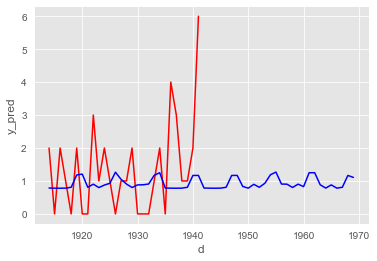

In [29]:
sns.lineplot(x='d', y='y_true', data=pred[ ( pred['item_id'] == 'FOODS_3_013' ) & ( pred['store_id'] == 'CA_2' ) ] , color='r')
sns.lineplot(x='d', y='y_pred', data=pred[ ( pred['item_id'] == 'FOODS_3_013' ) & ( pred['store_id'] == 'CA_2' ) ], color='b')
plt.show()

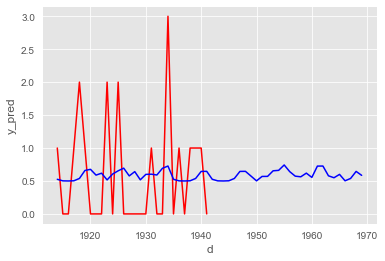

In [30]:
sns.lineplot(x='d', y='y_true', data=pred[ ( pred['item_id'] == 'FOODS_2_102' ) & ( pred['store_id'] == 'WI_2' ) ], color='r')
sns.lineplot(x='d', y='y_pred', data=pred[ ( pred['item_id'] == 'FOODS_2_102' ) & ( pred['store_id'] == 'WI_2' ) ], color='b')
plt.show()